In [62]:
!pip install nlpaug

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [63]:
import pandas as pd
import numpy as np
# from google.colab import drive
from nlpaug.augmenter.word import SynonymAug, ContextualWordEmbsAug
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
import os
from transformers import AutoModel
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [64]:
# drive.mount("/content/drive", force_remount=True)
# drive.mount('/content/drive')

In [65]:
df = pd.read_csv(r'/kaggle/input/kaspi-reviews-csv/kaspi_reviews.csv')
df = df[df['language'] == 'russian']
df_f_t = df.dropna()


In [66]:
df_f_t.groupby(by = 'rating').size()

rating
1.0      586
2.0      472
3.0      975
4.0     2867
5.0    12016
dtype: int64

In [67]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

aug_bert = ContextualWordEmbsAug(
    model_path='DeepPavlov/rubert-base-cased',
    action="substitute",
    aug_p=0.2,
    top_k=50,
    device='cuda'
)


In [68]:
def safe_augment(text):
    try:
        if isinstance(text, str) and text.strip():
            return aug_bert.augment(text)
    except Exception as e:
        print(f"Error augmenting text: {e}")
    return None

def aug(df, save_path=None):
    disp = df.groupby(by='rating').size()
    major = disp.nlargest(2).min()
    df_new = pd.DataFrame(columns=['rating', 'text', 'plus', 'minus'])

    for rating in disp.index:
        subset = df[df['rating'] == rating][['rating', 'text', 'plus', 'minus']]
        current_count = disp[rating]

        if current_count < major:
            df_new = pd.concat([df_new, subset])
            needed = major - current_count

            print(f"\nAugmenting rating {rating} ({current_count} → {major})")
            with tqdm(total=needed, desc=f'Rating {rating}', leave=True) as pbar:
                p = 0
                while p < needed:
                    row = subset.sample(1).iloc[0]
                    text_aug = safe_augment(row['text'])
                    plus_aug = safe_augment(row['plus'])
                    minus_aug = safe_augment(row['minus'])

                    if text_aug and plus_aug and minus_aug:
                        df_new = pd.concat([df_new, pd.DataFrame([{
                            'rating': rating,
                            'text': text_aug,
                            'plus': plus_aug,
                            'minus': minus_aug
                        }])], ignore_index=True)
                        p += 1
                        pbar.update(1)

        else:
            df_new = pd.concat([df_new, subset.sample(major)])

        if save_path:
            df_new.to_csv(save_path, index=False)

    return df_new



In [69]:
path_to_augmented_file = r'/kaggle/working/data_for_train_normalized.xlsx'

if not os.path.exists(path_to_augmented_file):
    print("Файл с аугментацией не найден, запускаю аугментацию...")
    df_new = aug(df_f_t)
    df_new.to_excel(path_to_augmented_file, index=False)
    print(f"Аугментированные данные сохранены по пути {path_to_augmented_file}")

else:
    print("Файл с аугментацией найден, загружаю данные...")
    df_new = pd.read_excel(path_to_augmented_file)

df_new['rating'].value_counts()

Файл с аугментацией найден, загружаю данные...


rating
1    2867
2    2867
3    2867
4    2867
5    2867
Name: count, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

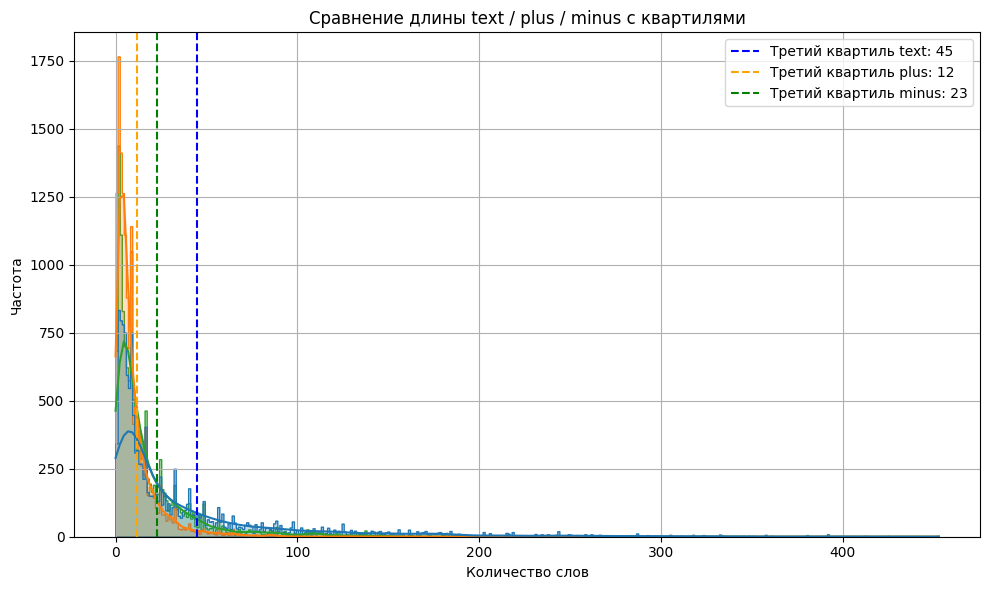

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Вычисляем длины
df_new['text_len'] = df_new['text'].astype(str).apply(lambda x: len(x.split()))
df_new['plus_len'] = df_new['plus'].astype(str).apply(lambda x: len(x.split()))
df_new['minus_len'] = df_new['minus'].astype(str).apply(lambda x: len(x.split()))

# Создаём long-формат таблицы
melted_df = df_new[['text_len', 'plus_len', 'minus_len']].melt(
    var_name='Тип текста', value_name='Длина (в словах)'
)

# Медианы
medians = {
    'text_len': df_new['text_len'].quantile(0.75),
    'plus_len': df_new['plus_len'].quantile(0.75),
    'minus_len': df_new['minus_len'].quantile(0.75)
}

# График
plt.figure(figsize=(10, 6))
sns.histplot(data=melted_df, x='Длина (в словах)', hue='Тип текста', element='step', kde=True)

# Добавляем вертикальные линии медиан
colors = {
    'text_len': 'blue',
    'plus_len': 'orange',
    'minus_len': 'green'
}
for column, median in medians.items():
    plt.axvline(median, linestyle='--', color=colors[column], label=f'Третий квартиль {column.replace("_len", "")}: {median:.0f}')

plt.title('Сравнение длины text / plus / minus с квартилями')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [71]:
def list_to_string(tokens):
    # Если элемент уже строка (не список), возвращаем как есть
    if isinstance(tokens, str):
        return tokens
    # Иначе объединяем список токенов в строку
    return ' '.join(tokens)

df_new['plus'] = df_new['plus'].apply(list_to_string)
df_new['minus'] = df_new['minus'].apply(list_to_string)
df_new['text'] = df_new['text'].apply(list_to_string)
df_new['plus'] = df_new['plus'].str.replace('[UNK]', '', regex=False)
df_new['minus'] = df_new['minus'].str.replace('[UNK]', '', regex=False)
df_new['text'] = df_new['text'].str.replace('[UNK]', '', regex=False)

In [72]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_new, test_size=0.2, random_state=42, stratify=df_new['rating'])

In [73]:
# df_new['plus'].iloc[6984,:]
train_df['plus']

6981                              ['Спина — симпатичная.']
2844     ['Работает анти - радар. На стекло Алекс прикл...
12603    Утюжок супер. Нагревается быстро, и крутит, и ...
582                                        Цена, удобство.
4514     [', удобная,  звук. Используется в качестве ча...
                               ...                        
8572                           [' км. Линия подключения.']
11681    Компактная, на присосках, просто разбирается и...
11888    Отличный чайник. Нашла то, что искала. Никогда...
7806     ['- 2015 < p > -  < br > - электрическая жидко...
10770    Представительный внешний вид, разумно подобран...
Name: plus, Length: 11468, dtype: object

In [74]:
print(len((train_df['plus'])))
print(len((train_df['minus'])))
print(len((train_df['text'])))
print(len(train_df['rating']))
# train_df['plus'] = train_df['plus'].apply(lambda x : " ".join(x))
# train_df['minus'] = train_df['minus'].apply(lambda x : " ".join(x))
# train_df['text'] = train_df['text'].apply(lambda x : " ".join(x))

train_df['plus']

11468
11468
11468
11468


6981                              ['Спина — симпатичная.']
2844     ['Работает анти - радар. На стекло Алекс прикл...
12603    Утюжок супер. Нагревается быстро, и крутит, и ...
582                                        Цена, удобство.
4514     [', удобная,  звук. Используется в качестве ча...
                               ...                        
8572                           [' км. Линия подключения.']
11681    Компактная, на присосках, просто разбирается и...
11888    Отличный чайник. Нашла то, что искала. Никогда...
7806     ['- 2015 < p > -  < br > - электрическая жидко...
10770    Представительный внешний вид, разумно подобран...
Name: plus, Length: 11468, dtype: object

## TF-IDF MLP

In [75]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_plus = TfidfVectorizer(max_features=5000)
tfidf_minus = TfidfVectorizer(max_features=5000)
tfidf_general = TfidfVectorizer(max_features=5000)

tfidf_plus.fit(train_df['plus'])
tfidf_minus.fit(train_df['minus'])
tfidf_general.fit(train_df['text'])

X_val_plus = tfidf_plus.transform(test_df['plus'])
X_val_minus = tfidf_minus.transform(test_df['minus'])
X_val_general = tfidf_general.transform(test_df['text'])

X_plus = tfidf_plus.transform(train_df['plus'])
X_minus = tfidf_minus.transform(train_df['minus'])
X_general = tfidf_general.transform(train_df['text'])

In [76]:
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack
from sklearn.metrics import classification_report, f1_score, accuracy_score
X_combined_train = hstack([X_general, X_plus, X_minus])  # sparse-матрица
X_combined_test = hstack([X_val_general, X_val_plus, X_val_minus])  # sparse-матрица

# 3. Обучаем MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(256, 64), random_state=42, max_iter=30)
mlp_model.fit(X_combined_train, train_df['rating'])

y_pred = mlp_model.predict(X_combined_test)


print("Accuracy:", accuracy_score(test_df['rating'], y_pred))
print("F1 Score (macro):", f1_score(test_df['rating'], y_pred, average='macro'))
print("F1 Score (weighted):", f1_score(test_df['rating'], y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(test_df['rating'], y_pred))

Accuracy: 0.7830484827345657
F1 Score (macro): 0.7816232300554509
F1 Score (weighted): 0.7816044426435685

Classification Report:
               precision    recall  f1-score   support

           1       0.91      0.93      0.92       574
           2       0.94      0.93      0.93       573
           3       0.78      0.84      0.81       573
           4       0.58      0.60      0.59       574
           5       0.70      0.62      0.66       573

    accuracy                           0.78      2867
   macro avg       0.78      0.78      0.78      2867
weighted avg       0.78      0.78      0.78      2867



/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


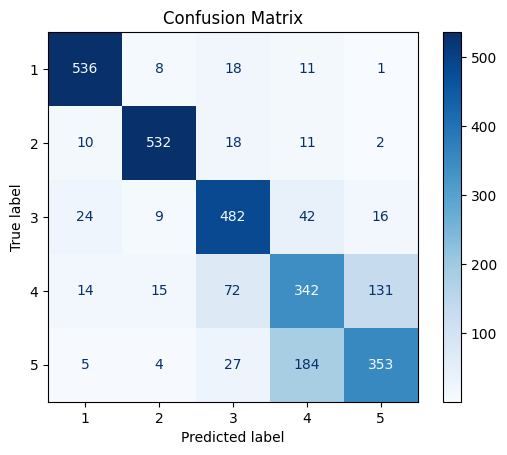

In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Предсказания модели
y_pred = mlp_model.predict(X_combined_test)

# Истинные метки
y_true = test_df['rating']

# Строим матрицу ошибок
cm = confusion_matrix(y_true, y_pred, labels=mlp_model.classes_)

# Визуализация матрицы ошибок
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [78]:
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import hstack
from sklearn.metrics import classification_report, f1_score, accuracy_score

# Объединяем признаки
X_train_combined = hstack([X_general, X_plus, X_minus])
X_test_combined = hstack([
    tfidf_general.transform(test_df['text']),
    tfidf_plus.transform(test_df['plus']),
    tfidf_minus.transform(test_df['minus'])
])

# Инициализация и обучение NB
nb_model = MultinomialNB()
nb_model.fit(X_train_combined, train_df['rating'])

# Предсказания на тесте
y_pred_nb = nb_model.predict(X_test_combined)

# Метрики
print("Accuracy:", accuracy_score(test_df['rating'], y_pred_nb))
print("F1 Score (macro):", f1_score(test_df['rating'], y_pred_nb, average='macro'))
print("F1 Score (weighted):", f1_score(test_df['rating'], y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(test_df['rating'], y_pred_nb))

Accuracy: 0.7279386117893268
F1 Score (macro): 0.7312084896820032
F1 Score (weighted): 0.7311957939902147

Classification Report:
               precision    recall  f1-score   support

           1       0.84      0.84      0.84       574
           2       0.86      0.81      0.83       573
           3       0.76      0.66      0.70       573
           4       0.53      0.64      0.58       574
           5       0.69      0.69      0.69       573

    accuracy                           0.73      2867
   macro avg       0.74      0.73      0.73      2867
weighted avg       0.74      0.73      0.73      2867



## Ber

In [79]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")


In [80]:
from torch.utils.data import DataLoader, Dataset
from transformers import DataCollatorWithPadding




class ReviewsDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=46):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        item = self.df.loc[idx]

        text = item['text'] if pd.notna(item['text']) else ""
        plus = item['plus'] if pd.notna(item['plus']) else ""
        minus = item['minus'] if pd.notna(item['minus']) else ""

        encoding_text = self.tokenizer(text, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt')
        encoding_plus = self.tokenizer(plus, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt')
        encoding_minus = self.tokenizer(minus, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt')

        return {
            'input_ids_text': encoding_text['input_ids'].squeeze(0),
            'attention_mask_text': encoding_text['attention_mask'].squeeze(0),
            'input_ids_plus': encoding_plus['input_ids'].squeeze(0),
            'attention_mask_plus': encoding_plus['attention_mask'].squeeze(0),
            'input_ids_minus': encoding_minus['input_ids'].squeeze(0),
            'attention_mask_minus': encoding_minus['attention_mask'].squeeze(0),
            'labels': torch.tensor(item['rating'], dtype=torch.long)-1,
            'text': item['text'],
            'plus': item['plus'],
            'minus': item['minus']
        }

train_dataset = ReviewsDataset(train_df, tokenizer, max_length=46)
test_dataset = ReviewsDataset(test_df, tokenizer, max_length=46)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [81]:
# def tokenize_column(column_data, tokenizer, max_length):
#     clean_texts = column_data.fillna("").astype(str).tolist()
#     return tokenizer(
#         clean_texts,
#         max_length=max_length,
#         padding='max_length',
#         truncation=True,
#         return_tensors='pt'
#     )

# # Токенизация для каждого поля
# text_tokens = tokenize_column(df_new['text'], tokenizer, max_length=46)
# plus_tokens = tokenize_column(df_new['plus'], tokenizer, max_length=46)
# minus_tokens = tokenize_column(df_new['minus'], tokenizer, max_length=46)


In [82]:
class ThreeInputModel(nn.Module):
    def __init__(self, pretrained_model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model_name)
        hidden_size = self.bert.config.hidden_size

        self.classifier = nn.Linear(hidden_size * 3, num_labels)

    def forward(
        self,
        input_ids_text=None, attention_mask_text=None,
        input_ids_plus=None, attention_mask_plus=None,
        input_ids_minus=None, attention_mask_minus=None
    ):
        batch_size = None
        max_length = None
        if input_ids_text is None:
            input_ids_text = torch.zeros((batch_size, max_length), dtype=torch.long).to(device)
            attention_mask_text = torch.zeros((batch_size, max_length), dtype=torch.long).to(device)

        if input_ids_plus is None:
            input_ids_plus = torch.zeros((batch_size, max_length), dtype=torch.long).to(device)
            attention_mask_plus = torch.zeros((batch_size, max_length), dtype=torch.long).to(device)

        if input_ids_minus is None:
            input_ids_minus = torch.zeros((batch_size, max_length), dtype=torch.long).to(device)
            attention_mask_minus = torch.zeros((batch_size, max_length), dtype=torch.long).to(device)

        outputs_text = self.bert(input_ids=input_ids_text, attention_mask=attention_mask_text)
        outputs_plus = self.bert(input_ids=input_ids_plus, attention_mask=attention_mask_plus)
        outputs_minus = self.bert(input_ids=input_ids_minus, attention_mask=attention_mask_minus)

        combined = torch.cat([
            outputs_text.last_hidden_state[:,0,:],
            outputs_plus.last_hidden_state[:,0,:],
            outputs_minus.last_hidden_state[:,0,:]
        ], dim=1)

        logits = self.classifier(combined)

        return logits

In [83]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [84]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids_text = batch['input_ids_text'].to(device)
            attention_mask_text = batch['attention_mask_text'].to(device)
            input_ids_plus = batch['input_ids_plus'].to(device)
            attention_mask_plus = batch['attention_mask_plus'].to(device)
            input_ids_minus = batch['input_ids_minus'].to(device)
            attention_mask_minus = batch['attention_mask_minus'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids_text, attention_mask_text,
                input_ids_plus, attention_mask_plus,
                input_ids_minus, attention_mask_minus
            )

            preds = outputs.argmax(dim=1).cpu().numpy()
            true_labels = labels.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(true_labels)

    report = classification_report(all_labels, all_preds, digits=4)
    print("Evaluation on validation set:\n", report)

In [85]:
path_to_augmented_file = r'/kaggle/working/model.pt'

if os.path.exists(path_to_augmented_file):
    print('Сохраненная модель найдена, загружаю')
    model = ThreeInputModel('cointegrated/rubert-tiny2', num_labels=5)  # передай нужные аргументы
    model.load_state_dict(torch.load(path_to_augmented_file))
    model.eval()
    
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained(save_path)
    
else:
    model = ThreeInputModel('cointegrated/rubert-tiny2', num_labels=5)
    model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
    epochs = 10
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps)
    
    criterion = nn.CrossEntropyLoss()
    max_length = 46
    model.train()
    for epoch in range(epochs):
        all_preds = []
        all_labels = []
        print(f"Epoch {epoch+1}/{epochs}")
        total_loss = 0
        for batch in tqdm(train_loader, desc="Training"):
            optimizer.zero_grad()
    
            input_ids_text = batch['input_ids_text'].to(device)
            attention_mask_text = batch['attention_mask_text'].to(device)
            input_ids_plus = batch['input_ids_plus'].to(device)
            attention_mask_plus = batch['attention_mask_plus'].to(device)
            input_ids_minus = batch['input_ids_minus'].to(device)
            attention_mask_minus = batch['attention_mask_minus'].to(device)
            labels = batch['labels'].to(device)
    
            outputs = model(
                input_ids_text, attention_mask_text,
                input_ids_plus, attention_mask_plus,
                input_ids_minus, attention_mask_minus
            )
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
    
            total_loss += loss.item()
            preds = outputs.argmax(dim=1).cpu().numpy()
            true_labels = labels.cpu().numpy()
    
            all_preds.extend(preds)
            all_labels.extend(true_labels)
        print(f"Average loss: {total_loss / len(train_loader):.4f}")
        evaluate_model(model, test_loader)
    save_path = "path_to_augmented_file"
    os.makedirs(save_path, exist_ok=True)
    torch.save(model.state_dict(), f"{save_path}/model.pt")
    tokenizer.save_pretrained(save_path)

Epoch 1/10


Training: 100%|██████████| 359/359 [00:27<00:00, 13.07it/s]


Average loss: 1.3312
Evaluation on validation set:
               precision    recall  f1-score   support

           0     0.5407    0.4861    0.5119       574
           1     0.4685    0.5585    0.5096       573
           2     0.5467    0.2147    0.3083       573
           3     0.4917    0.8258    0.6164       574
           4     0.7349    0.6143    0.6692       573

    accuracy                         0.5399      2867
   macro avg     0.5565    0.5399    0.5231      2867
weighted avg     0.5565    0.5399    0.5231      2867

Epoch 2/10


Training: 100%|██████████| 359/359 [00:26<00:00, 13.31it/s]


Average loss: 0.9144
Evaluation on validation set:
               precision    recall  f1-score   support

           0     0.7050    0.7160    0.7105       574
           1     0.6536    0.7277    0.6887       573
           2     0.6502    0.5515    0.5968       573
           3     0.6305    0.5470    0.5858       574
           4     0.6813    0.7871    0.7304       573

    accuracy                         0.6659      2867
   macro avg     0.6641    0.6659    0.6624      2867
weighted avg     0.6641    0.6659    0.6624      2867

Epoch 3/10


Training: 100%|██████████| 359/359 [00:27<00:00, 13.25it/s]


Average loss: 0.6236
Evaluation on validation set:
               precision    recall  f1-score   support

           0     0.8447    0.7962    0.8197       574
           1     0.8286    0.8185    0.8235       573
           2     0.7568    0.6789    0.7157       573
           3     0.5958    0.7369    0.6589       574
           4     0.7612    0.7120    0.7358       573

    accuracy                         0.7485      2867
   macro avg     0.7574    0.7485    0.7507      2867
weighted avg     0.7574    0.7485    0.7507      2867

Epoch 4/10


Training: 100%|██████████| 359/359 [00:26<00:00, 13.30it/s]


Average loss: 0.4001
Evaluation on validation set:
               precision    recall  f1-score   support

           0     0.8333    0.8972    0.8641       574
           1     0.9115    0.8272    0.8673       573
           2     0.8222    0.6859    0.7479       573
           3     0.5877    0.7822    0.6712       574
           4     0.7864    0.6684    0.7226       573

    accuracy                         0.7722      2867
   macro avg     0.7882    0.7722    0.7746      2867
weighted avg     0.7882    0.7722    0.7746      2867

Epoch 5/10


Training: 100%|██████████| 359/359 [00:27<00:00, 13.28it/s]


Average loss: 0.2669
Evaluation on validation set:
               precision    recall  f1-score   support

           0     0.9025    0.8711    0.8865       574
           1     0.8936    0.8796    0.8865       573
           2     0.7873    0.7557    0.7711       573
           3     0.6244    0.6864    0.6539       574
           4     0.7377    0.7312    0.7344       573

    accuracy                         0.7848      2867
   macro avg     0.7891    0.7848    0.7865      2867
weighted avg     0.7891    0.7848    0.7865      2867

Epoch 6/10


Training: 100%|██████████| 359/359 [00:27<00:00, 13.21it/s]


Average loss: 0.1857
Evaluation on validation set:
               precision    recall  f1-score   support

           0     0.8783    0.9181    0.8978       574
           1     0.9021    0.9005    0.9013       573
           2     0.8381    0.7225    0.7760       573
           3     0.5946    0.7334    0.6568       574
           4     0.7627    0.6562    0.7054       573

    accuracy                         0.7862      2867
   macro avg     0.7952    0.7862    0.7875      2867
weighted avg     0.7951    0.7862    0.7875      2867

Epoch 7/10


Training: 100%|██████████| 359/359 [00:27<00:00, 13.26it/s]


Average loss: 0.1325
Evaluation on validation set:
               precision    recall  f1-score   support

           0     0.8986    0.9111    0.9048       574
           1     0.9085    0.9005    0.9045       573
           2     0.7949    0.7644    0.7794       573
           3     0.5997    0.6655    0.6309       574
           4     0.7391    0.6824    0.7096       573

    accuracy                         0.7848      2867
   macro avg     0.7882    0.7848    0.7858      2867
weighted avg     0.7881    0.7848    0.7858      2867

Epoch 8/10


Training: 100%|██████████| 359/359 [00:27<00:00, 13.28it/s]


Average loss: 0.1003
Evaluation on validation set:
               precision    recall  f1-score   support

           0     0.8929    0.9146    0.9036       574
           1     0.9059    0.9075    0.9067       573
           2     0.8117    0.7522    0.7808       573
           3     0.6160    0.6429    0.6292       574
           4     0.7165    0.7190    0.7178       573

    accuracy                         0.7872      2867
   macro avg     0.7886    0.7872    0.7876      2867
weighted avg     0.7886    0.7872    0.7876      2867

Epoch 9/10


Training: 100%|██████████| 359/359 [00:27<00:00, 13.29it/s]


Average loss: 0.0807
Evaluation on validation set:
               precision    recall  f1-score   support

           0     0.9077    0.9077    0.9077       574
           1     0.9137    0.9058    0.9097       573
           2     0.8055    0.7661    0.7853       573
           3     0.5848    0.6969    0.6359       574
           4     0.7460    0.6457    0.6922       573

    accuracy                         0.7844      2867
   macro avg     0.7915    0.7844    0.7862      2867
weighted avg     0.7915    0.7844    0.7862      2867

Epoch 10/10


Training: 100%|██████████| 359/359 [00:27<00:00, 13.27it/s]


Average loss: 0.0706
Evaluation on validation set:
               precision    recall  f1-score   support

           0     0.9047    0.9094    0.9070       574
           1     0.9056    0.9040    0.9048       573
           2     0.8074    0.7609    0.7835       573
           3     0.6013    0.6620    0.6302       574
           4     0.7253    0.6911    0.7078       573

    accuracy                         0.7855      2867
   macro avg     0.7888    0.7855    0.7867      2867
weighted avg     0.7888    0.7855    0.7866      2867



In [86]:
save_path = "path_to_augmented_file"
os.makedirs(save_path, exist_ok=True)
torch.save(model.state_dict(), f"{save_path}/model.pt")
tokenizer.save_pretrained(save_path)

('path_to_augmented_file/tokenizer_config.json',
 'path_to_augmented_file/special_tokens_map.json',
 'path_to_augmented_file/vocab.txt',
 'path_to_augmented_file/added_tokens.json',
 'path_to_augmented_file/tokenizer.json')

In [87]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

emotion_model = "blanchefort/rubert-base-cased-sentiment"
emotion_tokenizer = AutoTokenizer.from_pretrained(emotion_model)
model_sent = AutoModelForSequenceClassification.from_pretrained(emotion_model).to(device)

def get_logits(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model_sent(**inputs)
    return outputs.logits.squeeze().tolist()

# load_path = r'/content/drive/MyDrive/Colab Notebooks/three_input_model_weights.pth'
# model = ThreeInputModel(num_labels = 5, pretrained_model_name= 'cointegrated/rubert-tiny2')
# model.load_state_dict(torch.load(load_path))
# model.to(device)
# model.eval()
# print("Модель загружена")

def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits))  # для числовой стабильности
    return exp_logits / exp_logits.sum()

def batch_softmax(logits_batch):
    # logits_batch — список списков (batch_size x num_classes)
    return [softmax(np.array(logits)) for logits in logits_batch]


In [88]:
import torch
import torch.nn.functional as F

def get_emotion_logits_from_full_text(text, plus_text=None, minus_text=None, max_length=512):
    # Склеиваем части отзыва в одну строку, пропуская None
    total_logits = []

    if text is not None:
        inputs = emotion_tokenizer(text, return_tensors='pt', truncation=True, max_length=max_length).to(device)
        logits = model_sent(**inputs).logits
        total_logits.append(logits)

    if plus_text is not None:
        inputs = emotion_tokenizer(plus_text, return_tensors='pt', truncation=True, max_length=max_length).to(device)
        logits = model_sent(**inputs).logits
        total_logits.append(logits)

    if minus_text is not None:
        inputs = emotion_tokenizer(minus_text, return_tensors='pt', truncation=True, max_length=max_length).to(device)
        logits = model_sent(**inputs).logits
        total_logits.append(logits)

    avg_logits = torch.stack(total_logits).mean(dim=0)

    return avg_logits

def predict(model, tokenizer, texts, plus_texts=None, minus_texts=None, max_length=46, device='cpu'):
    model.eval()
    with torch.no_grad():
        if texts is not None:
            inputs_text = tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt').to(device)

        inputs_plus = None
        if plus_texts is not None:
            inputs_plus = tokenizer(plus_texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt').to(device)

        inputs_minus = None
        if minus_texts is not None:
            inputs_minus = tokenizer(minus_texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt').to(device)

        logits = model(
            input_ids_text=inputs_text.input_ids if inputs_text is not None else None,
            attention_mask_text=inputs_text.attention_mask if inputs_text is not None else None,
            input_ids_plus=inputs_plus.input_ids if inputs_plus is not None else None,
            attention_mask_plus=inputs_plus.attention_mask if inputs_plus is not None else None,
            input_ids_minus=inputs_minus.input_ids if inputs_minus is not None else None,
            attention_mask_minus=inputs_minus.attention_mask if inputs_minus is not None else None
        )

        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)+1

        emotion_logits = []

        if emotion_model and emotion_tokenizer:
            for i, text in enumerate(texts):
              plus_text = plus_texts[i] if plus_texts is not None else None
              minus_text = minus_texts[i] if minus_texts is not None else None
              logits = get_emotion_logits_from_full_text(text, plus_text, minus_text, max_length=512)
              probs_emo = F.softmax(logits[0], dim=0).cpu().tolist()
              emotion_logits.append(probs_emo)
        else:
            emotion_logits = None

    return {
        "preds": preds.cpu().tolist(),
        "probs": probs.cpu().tolist(),
        "emotion_logits": emotion_logits}


In [89]:
# # Пишем верхнеуровневую модель, для классификации

# mlp_proba = mlp_model.predict_proba(X_combined_train)
# print("mlp_get")
# nb_proda = nb_model.predict_proba(X_combined_train)
# print("nb_get")
# bert_proba = predict(model,tokenizer, train_df['text'].fillna("").astype(str).tolist(), train_df['plus'].fillna("").astype(str).tolist(),train_df['minus'].fillna("").astype(str).tolist())["probs"]
# print("bert_get")

In [90]:
# # Склеиваем вероятности из всех трёх моделей
# from sklearn.ensemble import RandomForestClassifier
# X_stack = np.hstack([nb_proda, mlp_proba, bert_proba])

# # Обучаем линейную модель (например, логистическая регрессия)
# meta_model = RandomForestClassifier()
# meta_model.fit(X_stack, train_df['rating'])

# # Предсказание
# final_proba = meta_model.predict_proba(X_stack)
# final_pred = meta_model.predict(X_stack)

In [91]:
# mlp_proba = mlp_model.predict_proba(X_combined_test)
# print("mlp_get")
# nb_proda = nb_model.predict_proba(X_combined_test)
# print("nb_get")
# bert_proba = predict(model,tokenizer, test_df['text'].fillna("").astype(str).tolist(), test_df['plus'].fillna("").astype(str).tolist(),test_df['minus'].fillna("").astype(str).tolist())["probs"]
# print("bert_get")
# X_stack = np.hstack([nb_proda, mlp_proba, bert_proba])

In [92]:
# final_pred = meta_model.predict(X_stack)

In [93]:
# print("Accuracy:", accuracy_score(test_df['rating'], final_pred))
# print("F1 Score (macro):", f1_score(test_df['rating'], final_pred, average='macro'))
# print("F1 Score (weighted):", f1_score(test_df['rating'], final_pred, average='weighted'))
# print("\nClassification Report:\n", classification_report(test_df['rating'], final_pred))

In [94]:
texts = df['text'][:1000].fillna("").astype(str).tolist()
plus_texts = df['plus'][:1000].fillna("").astype(str).tolist()
minus_texts = df['minus'][:1000].fillna("").astype(str).tolist()


result = predict(model, tokenizer, texts, plus_texts, minus_texts, max_length=46, device=device)

[1, 5, 5, 4, 5, 5, 1, 5, 5, 5, 5, 5, 5, 4, 1, 1, 5, 5, 5, 5, 4, 5, 5, 3, 5, 4, 5, 5, 2, 5, 5, 5, 1, 1, 5, 1, 1, 5, 5, 1, 1, 3, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 1, 1, 1, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 4, 5, 5, 2, 5, 3, 5, 5, 1, 5, 5, 5, 5, 1, 1, 5, 1, 5, 5, 5, 5, 2, 1, 4, 3, 5, 5, 2, 5, 5, 4, 5, 2, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 1, 5, 5, 4, 5, 5, 1, 5, 5, 5, 5, 4, 5, 1, 5, 1, 5, 5, 5, 5, 1, 5, 4, 4, 1, 5, 1, 5, 5, 1, 5, 5, 5, 1, 5, 5, 5, 5, 4, 5, 1, 5, 4, 4, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 1, 5, 5, 3, 5, 5, 5, 1, 5, 5, 5, 5, 4, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 4, 5, 5, 3, 2, 5, 5, 4, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 1, 5, 4, 5, 5, 5, 1, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

In [116]:
def NPS_analysis(result):
  star = result['preds']
  emo = result['emotion_logits']
  NPS = []
  emo_h_l = []
  for i in range(len(star)):
    star_h = star[i]
    emo_h = emo[i]
    emo_h_n = emo_h[0]
    emo_h_p = emo_h[1]
    emo_h_nega = emo_h[2]
    emo_avg = (emo_h_p - emo_h_nega + 1/2*emo_h_n)
    nps_score = round((star[i]-1)/4 * emo_avg,1)
    if nps_score < 0:
        nps_score = 0
    NPS.append(nps_score)
  return NPS

NPS = NPS_analysis(result)


Создание облака слов

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



<Axes: xlabel='count'>

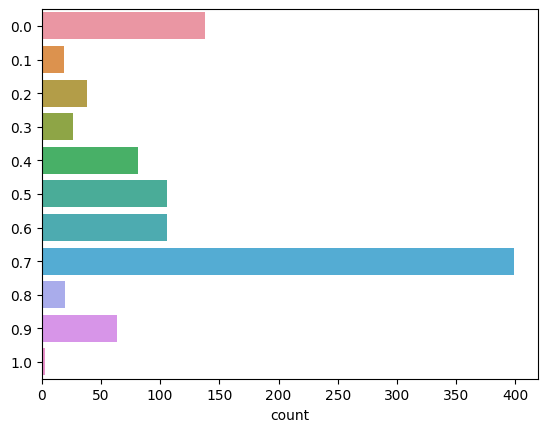

In [117]:
import seaborn as sns
sns.countplot(y = NPS)

In [97]:
df_p = pd.DataFrame({
    'preds': result['preds'],
    'labels':  df['rating'][:1000]
})

print(df_p)
# Группируем по парам (preds, labels), считаем количество отзывов
count_df = df_p.groupby(['preds', 'labels']).size().reset_index(name='count')

# Строим scatter plot, где size — это количество отзывов (count)
fig = px.scatter(
    count_df,
    x='preds',
    y='labels',
    size='count',    # размер точек по количеству
    size_max=40,     # максимальный размер точек (можно настроить)
    title='Количество отзывов по парам (предсказание, метка)',
    labels={'preds': 'Предсказанные звезды', 'labels': 'Настоящие метки'}
)

fig.show()

      preds  labels
0         1     5.0
1         5     5.0
2         5     5.0
4         4     4.0
5         5     5.0
...     ...     ...
1035      5     5.0
1036      3     2.0
1037      5     5.0
1038      1     5.0
1039      5     5.0

[1000 rows x 2 columns]


In [98]:
count_df

,preds,labels,count
0,1,1.0,64
1,1,2.0,14
2,1,3.0,23
3,1,4.0,3
4,1,5.0,23
5,2,1.0,10
6,2,2.0,4
7,2,3.0,4
8,2,4.0,3
9,3,1.0,7


In [99]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [100]:
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

texts_by_class_general = defaultdict(list)
texts_by_class_plus = defaultdict(list)
texts_by_class_minus = defaultdict(list)

for text, plus, minus, label in zip(texts, plus_texts, minus_texts, predictions):
    texts_by_class_general[label].append(text)
    texts_by_class_plus[label].append(plus)
    texts_by_class_minus[label].append(minus)

nltk.download("punkt")
nltk.download("stopwords")
stop_words = set(stopwords.words("russian"))

NameError: name 'predictions' is not defined

In [ ]:
def color_func_factory(color):
    def color_func(*args, **kwargs):
        return color
    return color_func

# Генерация комбинированного облака
def generate_combined_wordcloud(texts_general, texts_plus, texts_minus, class_label):
    stop_words = set(stopwords.words("russian"))

    # Предобработка
    def preprocess_texts(texts):
        return " ".join([
            word.lower() for text in texts for word in text.split()
            if word.isalpha() and word.lower() not in stop_words and len(word) > 2
        ])

    general_text = preprocess_texts(texts_general)
    plus_text = preprocess_texts(texts_plus)
    minus_text = preprocess_texts(texts_minus)

    # Объединённая частота слов (с пометкой откуда слово)
    combined_frequencies = defaultdict(int)
    word_sources = {}

    for word in general_text.split():
        combined_frequencies[word] += 1
        word_sources[word] = "blue"

    for word in plus_text.split():
        combined_frequencies[word] += 1
        word_sources[word] = "green"

    for word in minus_text.split():
        combined_frequencies[word] += 1
        word_sources[word] = "red"

    # Генерация облака
    wc = WordCloud(width=1000, height=600, background_color="white", max_words=200)
    wc.generate_from_frequencies(combined_frequencies)

    # Цвета по источнику
    def combined_color_func(word, *args, **kwargs):
        return word_sources.get(word, "gray")

    plt.figure(figsize=(12, 6))
    plt.imshow(wc.recolor(color_func=combined_color_func), interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Оценка: {class_label+1} — Облако слов", fontsize=16)
    plt.show()

In [ ]:
for class_label in texts_by_class_general:
    generate_combined_wordcloud(
        texts_general=texts_by_class_general[class_label],
        texts_plus=texts_by_class_plus[class_label],
        texts_minus=texts_by_class_minus[class_label],
        class_label=class_label
    )

Сохранение модели

In [ ]:
import torch

save_path = r'/content/drive/MyDrive/Colab Notebooks/three_input_model_weights.pth'


torch.save(model.state_dict(), save_path)
print(f"Модель сохранена в {save_path}")

Загрузка предобученной

In [ ]:
load_path = r'/content/drive/MyDrive/Colab Notebooks/three_input_model_weights.pth'
model = ThreeInputModel(num_labels = 5, pretrained_model_name= 'cointegrated/rubert-tiny2')
model.load_state_dict(torch.load(load_path))
model.eval()
print("Модель загружена")

In [ ]:
tokenizer.save_pretrained('/content/drive/MyDrive/models/tokenizer_dir')



In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/models/tokenizer_dir')

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name = "blanchefort/rubert-base-cased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def get_logits(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.logits.squeeze().tolist()  # это и есть логиты: [neg, neu, pos]


In [ ]:
logits_general = get_logits(general_text)
logits_positive = get_logits(positive_part)
logits_negative = get_logits(negative_part)